In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns

from statsmodels.tsa.stattools import adfuller, acovf, acf, pacf
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import kstest
from arch import arch_model
import scipy.stats as st

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
sns.set()
matplotlib.rcParams['figure.figsize'] = (12, 7)
pd.set_option('display.float_format','{:.4f}'.format)

In [4]:
def t_student_tests(data):
    # Parametry dla rozkładu t-Studenta
    d_f, loc, sc = st.t.fit(data)
    print(d_f, loc, sc)
    # Test t-Studenta dla średniej
    t_stat, t_p_value = st.ttest_1samp(data, popmean=loc)
    
    # Test Kolmogorova-Smirnova z rozkładem t-Studenta
    ks_stat, ks_p_value = st.kstest(data, st.t(d_f, loc, sc).cdf)
    
    # Interpretacja wyników
    print("Test t-Studenta:")
    print(f"Statystyka t: {t_stat:.4f}, p-wartość: {t_p_value:.4f}")
    print("Wynik testu t-Studenta:")
    if t_p_value < 0.05:
        print("Odrzucamy hipotezę zerową: średnia próby różni się od zadanej wartości.")
    else:
        print("Nie ma podstaw do odrzucenia hipotezy zerowej: średnia próby jest równa zadanej wartości.")
    
    print("\nTest Kolmogorova-Smirnova:")
    print(f"Statystyka: {ks_stat:.4f}, p-wartość: {ks_p_value:.4f}")
    print("Wynik testu Kolmogorova-Smirnova:")
    if ks_p_value < 0.05:
        print("Odrzucamy hipotezę zerową: dane nie pochodzą z rozkładu t-Studenta.")
    else:
        print("Nie ma podstaw do odrzucenia hipotezy zerowej: dane mogą pochodzić z rozkładu t-Studenta.")


[*********************100%***********************]  1 of 1 completed


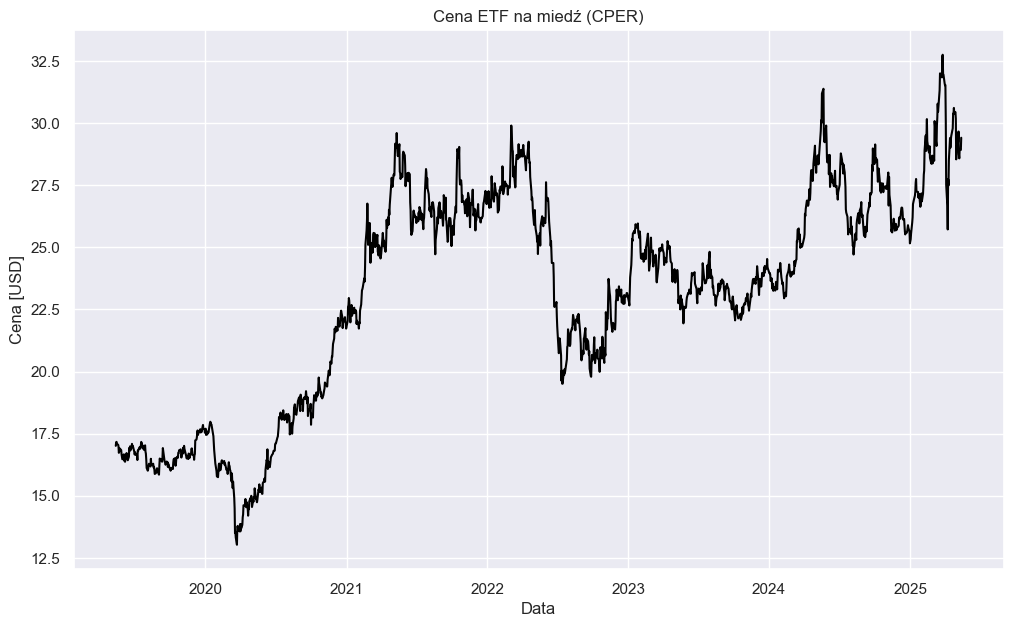

In [ ]:
copper = yf.download('CPER', period='6y')['Close']

plt.plot(copper, color = 'black')
plt.title('Cena ETF na miedź (CPER)')
plt.ylabel('Cena [USD]')
plt.xlabel('Data')
plt.grid(True)
plt.show()

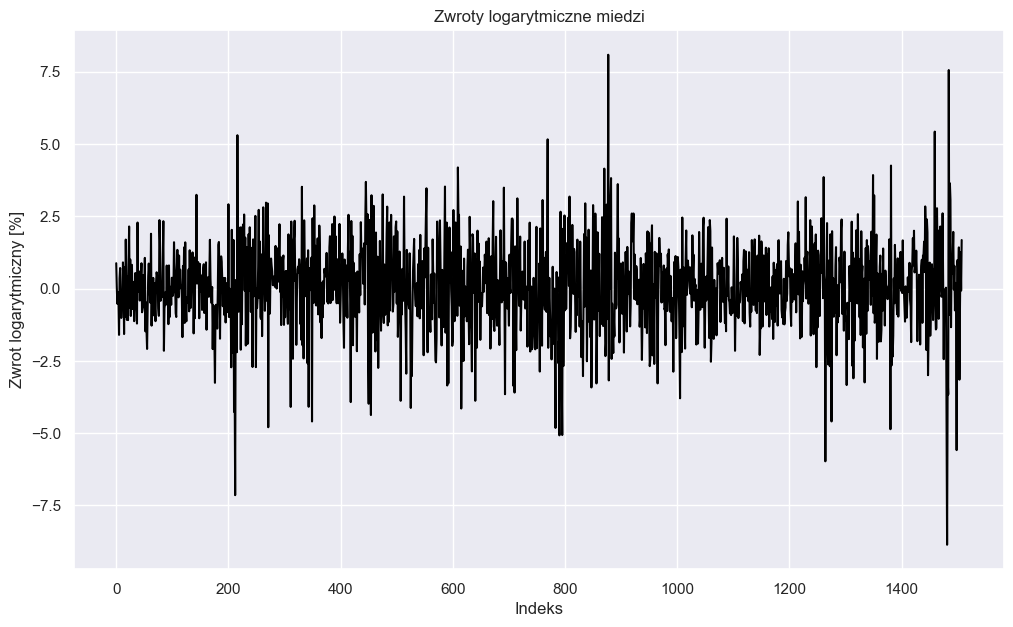

In [7]:
log_returns_copper = np.log(copper / copper.shift(1)).dropna()
log_returns_copper = 100*np.ravel(log_returns_copper)
plt.plot(log_returns_copper, color = 'black')
plt.title('Zwroty logarytmiczne miedzi')
plt.ylabel('Zwrot logarytmiczny [%]')
plt.xlabel('Indeks')
plt.grid(True)
plt.show()

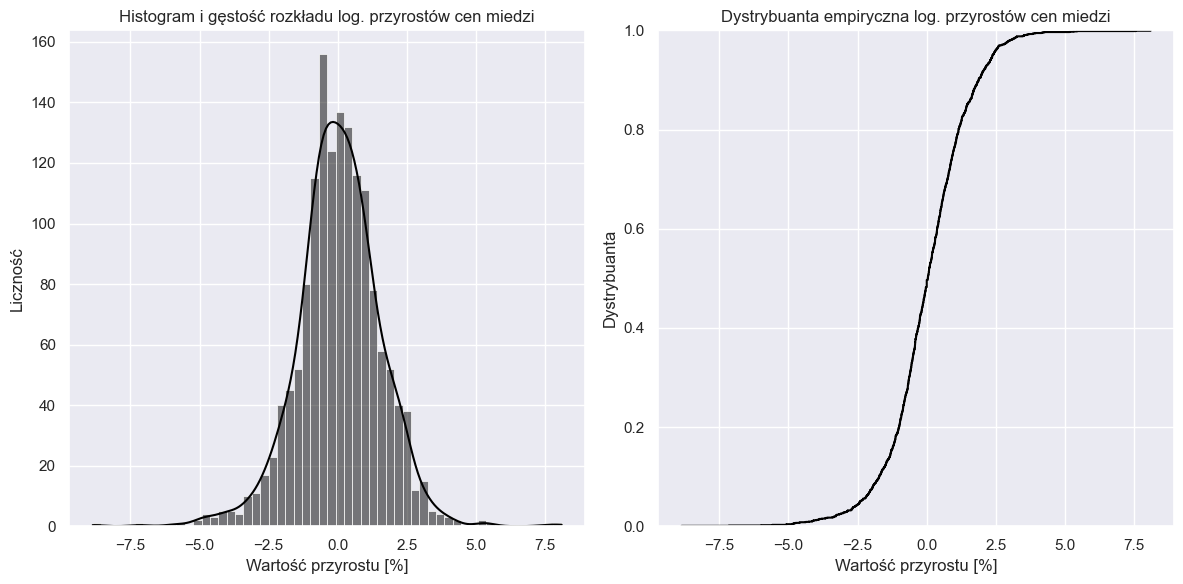

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histogram i gęstość rozkładu na pierwszym subplocie
sns.histplot(log_returns_copper, kde=True, ax=axes[0], color = 'black')
axes[0].set_title('Histogram i gęstość rozkładu log. przyrostów cen miedzi')
axes[0].set_xlabel('Wartość przyrostu [%]')
axes[0].set_ylabel('Liczność')

# Dystrybuanta empiryczna na drugim subplocie
sns.ecdfplot(log_returns_copper, ax=axes[1], color = 'black')
axes[1].set_title('Dystrybuanta empiryczna log. przyrostów cen miedzi')
axes[1].set_xlabel('Wartość przyrostu [%]')
axes[1].set_ylabel('Dystrybuanta')

# Wyświetlanie wykresu
plt.tight_layout()
plt.show()

In [9]:
t_student_tests(log_returns_copper)
d_f, loc, sc = st.t.fit(log_returns_copper)
d_f = 6

5.943597075008984 0.053530105603241104 1.2255069222601669
Test t-Studenta:
Statystyka t: -0.4440, p-wartość: 0.6571
Wynik testu t-Studenta:
Nie ma podstaw do odrzucenia hipotezy zerowej: średnia próby jest równa zadanej wartości.

Test Kolmogorova-Smirnova:
Statystyka: 0.0177, p-wartość: 0.7268
Wynik testu Kolmogorova-Smirnova:
Nie ma podstaw do odrzucenia hipotezy zerowej: dane mogą pochodzić z rozkładu t-Studenta.


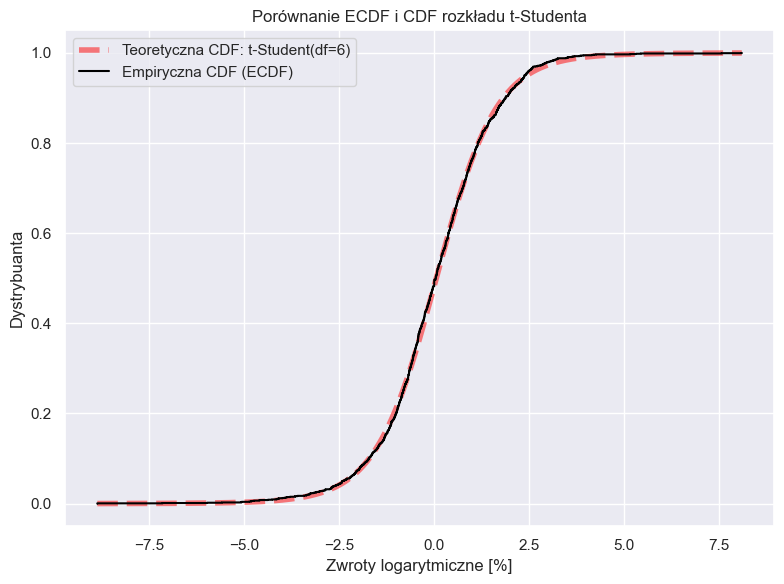

In [10]:
ecdf = ECDF(log_returns_copper)

# Siatka do wykresu
x = np.linspace(min(log_returns_copper), max(log_returns_copper), 1000)
t_cdf = st.t.cdf(x, df=d_f, loc=loc, scale=sc)

# Wykres
plt.figure(figsize=(8, 6))
plt.plot(x, t_cdf, label=f'Teoretyczna CDF: t-Student(df={d_f})', color='red', linewidth=4, alpha=0.5, linestyle='dashed')
plt.step(ecdf.x, ecdf.y, label='Empiryczna CDF (ECDF)', where='post', color='black')
plt.title('Porównanie ECDF i CDF rozkładu t-Studenta')
plt.xlabel('Zwroty logarytmiczne [%]')
plt.ylabel('Dystrybuanta')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ZADANIE 1

## a)

In [12]:
var_95_1 = -st.t(d_f, loc, sc).ppf(0.05)
var_99_1 = -st.t(d_f, loc, sc).ppf(0.01)
var_95_1, var_99_1

(2.327850779367715, 3.7978317769981675)

Poprawiona funkcja plot

In [13]:
def plot_var(values, VaR95, VaR99, title='Zwroty'):
    values = pd.Series(values)   # bezpieczne rzutowanie
    plt.figure(figsize=(16, 8))
    plt.plot(values.index, values, 'o', markersize=3, label='Zwrot')
    plt.title(title, fontsize=18)
    plt.xlabel('Obserwacja')
    plt.ylabel('Wartość')
    
    # kwantyle empiryczne
    Q95, Q99 = np.quantile(values, [0.95, 0.99])
    plt.axhline(Q95, color='k', lw=2, label=f'Q95 emp. = {Q95:.2f}')
    plt.axhline(Q99, color='brown', lw=2, label=f'Q99 emp. = {Q99:.2f}')
    
    # VaR – zakładamy, że podajesz dodatnią liczbę straty
    plt.axhline(-VaR95, color='k', ls='--', lw=2, label=f'VaR95 = {VaR95:.2f}')
    plt.axhline(-VaR99, color='brown', ls='--', lw=2, label=f'VaR99 = {VaR99:.2f}')
    
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


Funkcja plot do histogramów - Maro kazał

In [14]:
def plot_var_hist(values, VaR95, VaR99, title='Histogram zwrotów', kde=True):
    """
    values  – 1‑D array / Series ze zwrotami (ujemne= straty)
    VaR95, VaR99 – dodatnie liczby strat (np. 2.33 oznacza -2.33 w szeregu)
    """
    values = pd.Series(values)
    plt.figure(figsize=(14, 7))
    sns.histplot(values, kde=kde, color='grey', edgecolor='black', bins=60)
    
    Q95, Q99 = np.quantile(values, [0.95, 0.99])   # empiryczne prawe ogony
    plt.axvline(Q95,  color='k',     lw=2, label=f'Q95 emp. = {Q95:.2f}')
    plt.axvline(Q99,  color='brown', lw=2, label=f'Q99 emp. = {Q99:.2f}')
    
    # VaR – rysujemy po stronie strat (ujemnie)
    plt.axvline(-VaR95, color='k',     ls='--', lw=2, label=f'VaR95 = {VaR95:.2f}')
    plt.axvline(-VaR99, color='brown', ls='--', lw=2, label=f'VaR99 = {VaR99:.2f}')
    
    plt.title(title, fontsize=16)
    plt.xlabel('Zwrot [%]')
    plt.ylabel('Liczność')
    plt.legend()
    plt.grid(alpha=.3)
    plt.tight_layout()
    plt.show()

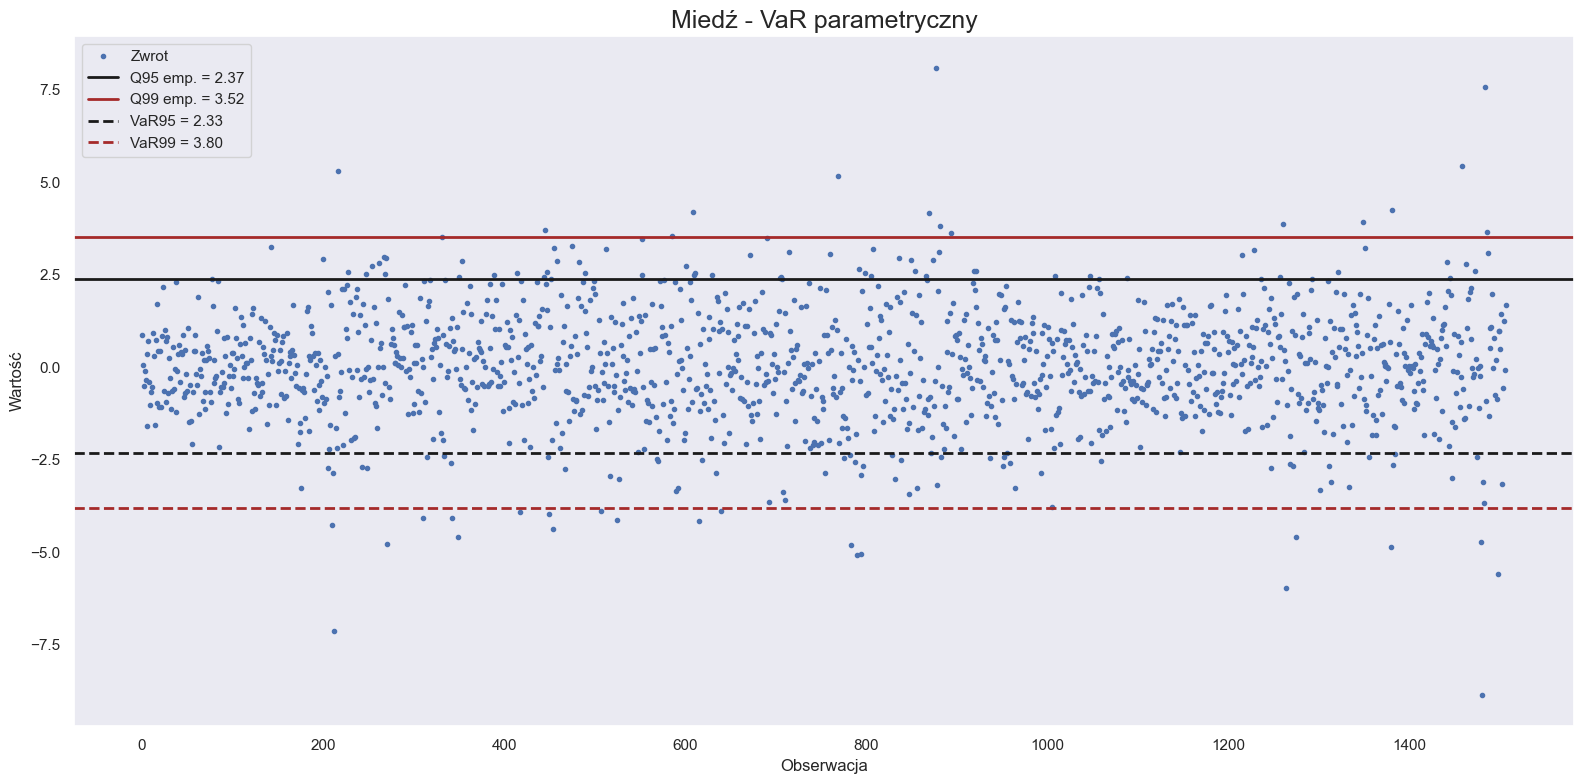

In [15]:
plot_var(log_returns_copper, var_95_1, var_99_1,
         title='Miedź - VaR parametryczny')


histogram

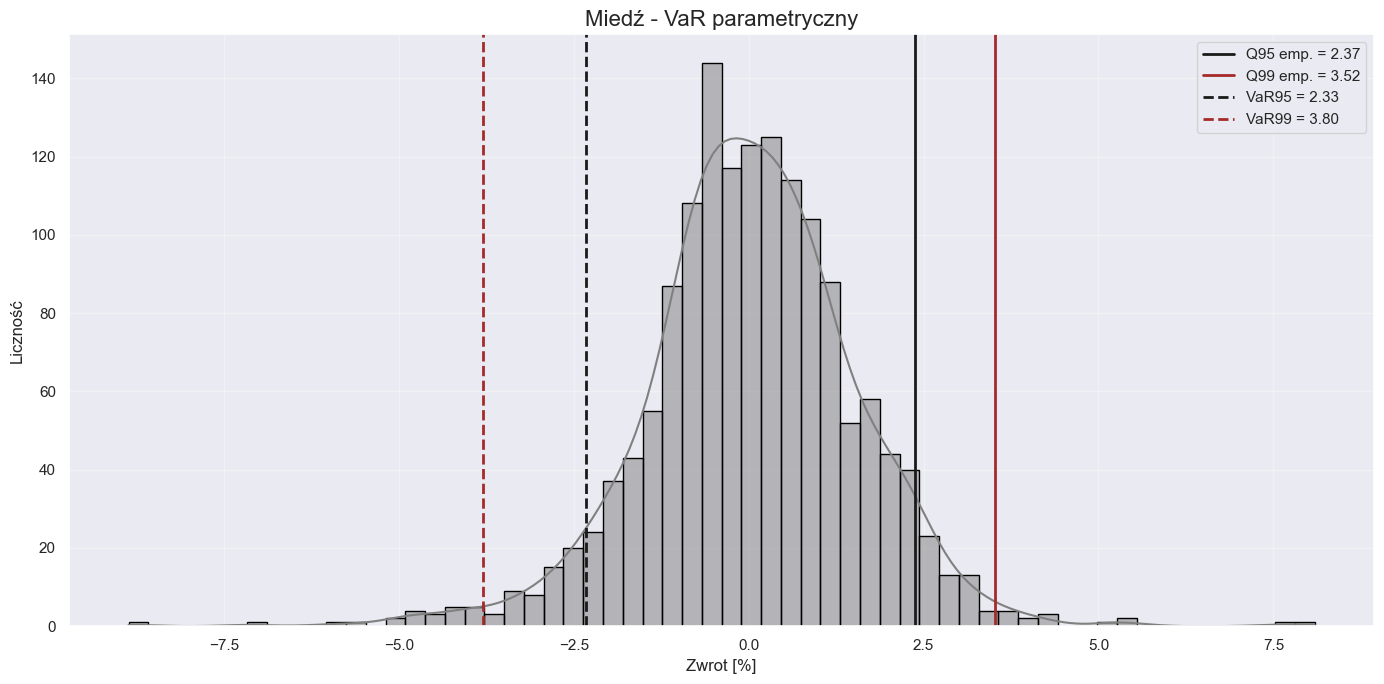

In [16]:
plot_var_hist(log_returns_copper, var_95_1, var_99_1,
              title='Miedź - VaR parametryczny')

Dlaczego empiryczny Q95 (2.37) ≠ parametryczny VaR95 (2.33)?

Empiryka bierze 5 % skrajnych danych (historia).

Parametryka używa wzoru t‑Studenta – lekko odmienny kształt ogona → delikatnie niższy VaR. Różnica kilkusetetnych % jest naturalna.

## b) 
#### i)

Mając próbkę zwrotów $(R_1, R_2, \ldots, R_t)$, obliczamy empiryczny kwantyl na poziomie $1 - \alpha$ (ozn. $q_{1-\alpha}$), to znaczy taki punkt, poniżej którego znajduje się $(1 - \alpha)\%$ obserwacji zwrotów. Wtedy wartość zagrożona (Value at Risk) przy poziomie ufności $\alpha$ wyraża się wzorem: $VaR_\alpha = -q_{1-\alpha}$

gdzie znak minus oznacza, że VaR jest wyrażony jako dodatnia liczba odpowiadająca potencjalnej stracie (ujemnemu zwrotowi).

W praktyce obliczyliśmy:

* $VaR_{95\%} = -q_{5\%}$ 
* $VaR_{99\%} = -q_{1\%}$ 



In [19]:
VaR95 = -np.quantile(log_returns_copper, 0.05)
VaR99 = -np.quantile(log_returns_copper, 0.01)
VaR95, VaR99

(2.3996589377115023, 4.1260088353655995)

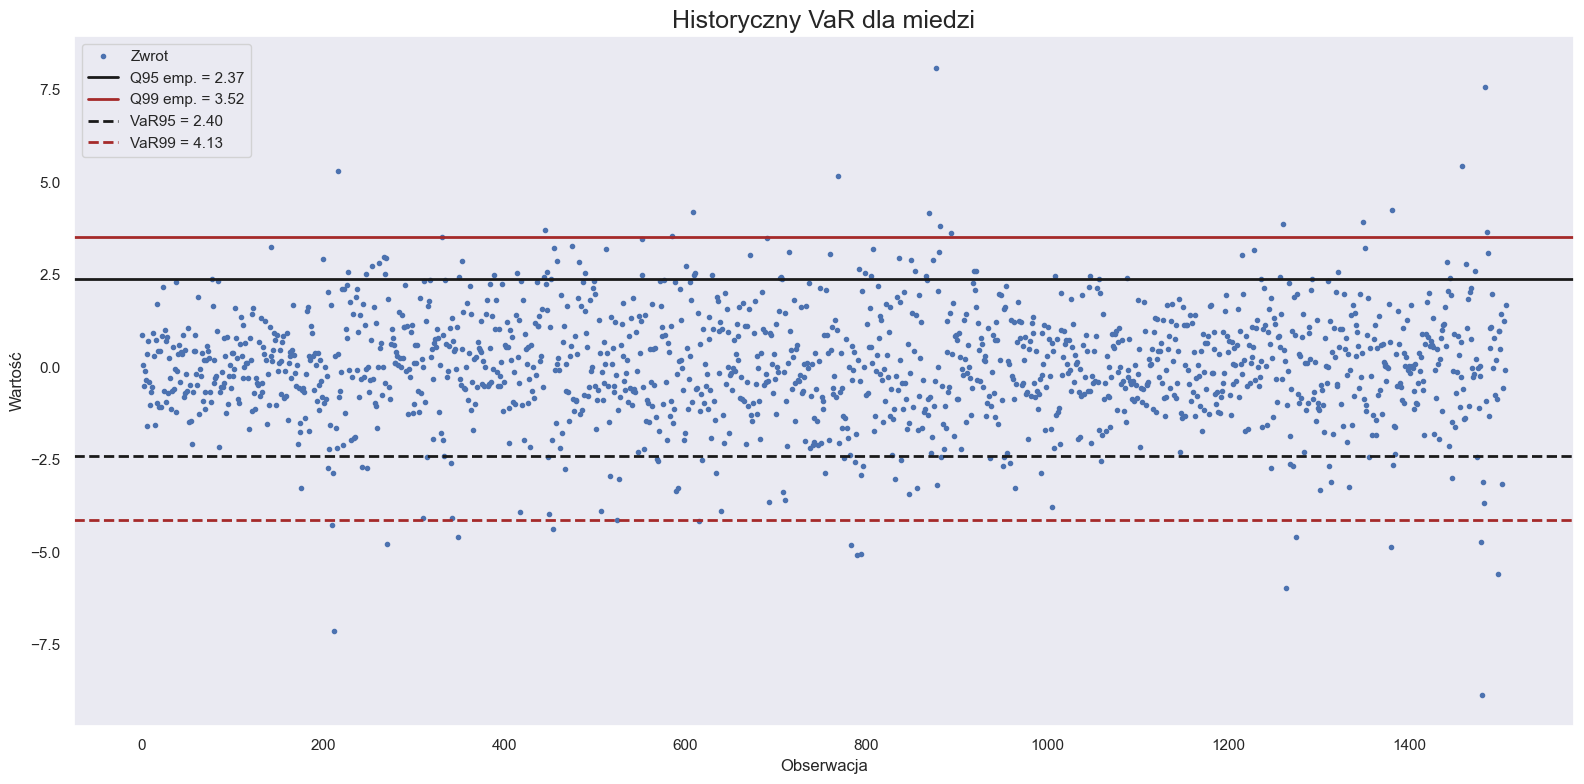

In [20]:
plot_var(log_returns_copper, VaR95, VaR99, title='Historyczny VaR dla miedzi')

histogramikowy świat

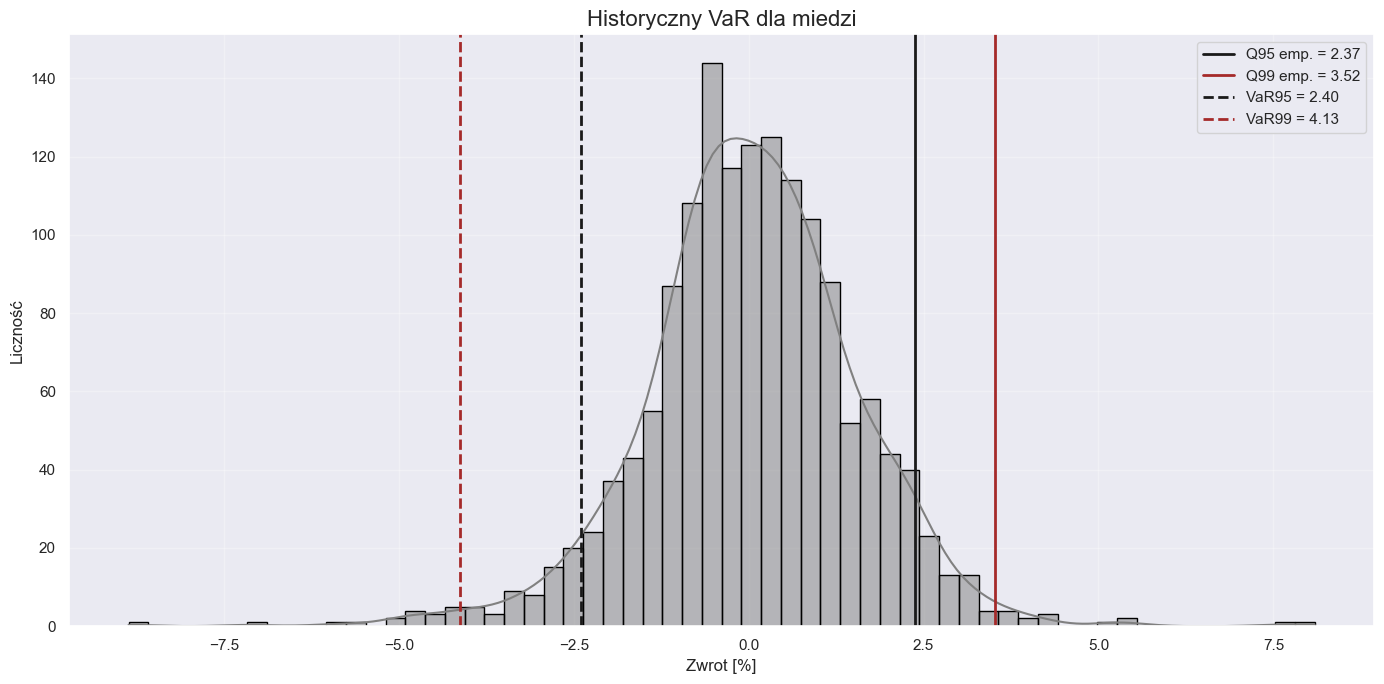

In [21]:
plot_var_hist(log_returns_copper, VaR95, VaR99, title='Historyczny VaR dla miedzi')

#### ii)

Metoda ważonej symulacji historycznej (Weighted Historical Simulation - WHS) polega na przypisaniu większych wag do bardziej aktualnych obserwacji. Jest to rozszerzenie standardowej metody symulacji historycznej, które pozwala lepiej uwzględnić zmienne warunki rynkowe.

W metodzie tej wprowadzamy system wag, w którym najnowsze obserwacje mają większy wpływ na wynik niż obserwacje dawniejsze. Wagi określamy przy użyciu parametru $\lambda$ (lambda), który przyjmuje wartości z przedziału $(0,1)$. Typowa wartość $\lambda$ to 0.97-0.99.

Podstawą metody jest następujący system wag:

$$w_t = \frac{(1-\lambda)\lambda^{t-1}}{\sum_{i=1}^{T}(1-\lambda)\lambda^{i-1}} = \frac{(1-\lambda)\lambda^{t-1}}{1-\lambda^T}$$

gdzie:
- $w_t$ to waga dla obserwacji $t$ (licząc od najnowszej)
- $\lambda$ to parametr spadku wagi (decay factor)
- $T$ to liczba wszystkich obserwacji

Dla dużych $T$ mianownik dąży do 1, więc można stosować uproszczoną formułę:

$$w_t \approx (1-\lambda)\lambda^{t-1}$$

In [22]:
# Funkcja do obliczania wag dla metody ważonej symulacji historycznej
def oblicz_wagi(n, lambda_param=0.97):
    """
    Oblicza wagi dla metody ważonej symulacji historycznej.
    
    Parametry:
    - n: liczba obserwacji
    - lambda_param: parametr wygładzania (domyślnie 0.97)
    
    Zwraca:
    - wagi: wektor wag dla każdej obserwacji
    """
    wagi = np.zeros(n)
    for i in range(n):
        wagi[i] = (1 - lambda_param) * lambda_param**i
    
    # Normalizacja wag, aby suma wynosiła 1
    wagi = wagi / wagi.sum()
    
    return wagi

Mając obliczone wagi, możemy przystąpić do obliczenia ważonego kwantyla, który posłuży nam do wyznaczenia VaR. Ważony kwantyl rzędu $\alpha$ dla szeregu danych $(x_1, x_2, ..., x_n)$ z przypisanymi wagami $(w_1, w_2, ..., w_n)$ definiujemy następująco:

1. Sortujemy pary $(x_i, w_i)$ względem wartości $x_i$ (od najmniejszej do największej)
2. Obliczamy skumulowane wagi $cw_i = \sum_{j=1}^{i} w_j$
3. Ważony kwantyl rzędu $\alpha$ to najmniejsza wartość $x_i$, dla której $cw_i \geq \alpha$

W praktyce, do wyznaczenia VaR na poziomie ufności $\alpha$ przy pomocy metody ważonej symulacji historycznej, należy wyznaczyć ważony kwantyl rzędu $(1-\alpha)$ dla szeregu stóp zwrotu.

In [23]:
def kwantyl_wazony(dane, wagi, alpha):
    """
    Oblicza ważony kwantyl dla danych z przypisanymi wagami.
    
    Parametry:
    - dane: szereg danych
    - wagi: wektor wag odpowiadających danym
    - alpha: poziom kwantyla (np. 0.05 dla 5% kwantyla)
    
    Zwraca:
    - kwantyl: ważony kwantyl rzędu alpha
    """
    # Sortowanie danych i wag według wartości danych
    idx = np.argsort(dane)
    sorted_dane = dane[idx]
    sorted_wagi = wagi[idx]
    
    # Obliczanie skumulowanych wag
    cum_wagi = np.cumsum(sorted_wagi)
    
    # Znalezienie indeksu, dla którego skumulowana waga przekracza alpha
    j = np.argmax(cum_wagi >= alpha)
    
    return sorted_dane[j]

Mając zdefiniowane funkcje pomocnicze, możemy przystąpić do implementacji metody VaR z wykorzystaniem ważonej symulacji historycznej. 

Algorytm obliczania VaR metodą ważonej symulacji historycznej można przedstawić następująco:

1. Dla danego szeregu czasowego logarytmicznych stóp zwrotu $(r_1, r_2, ..., r_T)$, gdzie $r_1$ jest najnowszą obserwacją, obliczamy wagi $(w_1, w_2, ..., w_T)$ przy użyciu parametru $\lambda$
2. Wyznaczamy ważony kwantyl rzędu $(1-\alpha)$ dla szeregu stóp zwrotu z przypisanymi wagami
3. VaR na poziomie ufności $\alpha$ jest równy wartości bezwzględnej tego kwantyla (ze znakiem minus, jeśli kwantyl jest ujemny)

Ta metoda, w przeciwieństwie do zwykłej symulacji historycznej, pozwala na lepsze odzwierciedlenie aktualnych warunków rynkowych, przypisując większą wagę do najnowszych obserwacji. Dzięki temu VaR szybciej reaguje na zmiany w zmienności rynku.

In [24]:
# Funkcja do obliczania VaR metodą ważonej symulacji historycznej
def var_wazony_symulacja_historyczna(returns, alpha, lambda_param=0.97):
    """
    Oblicza Value at Risk metodą ważonej symulacji historycznej.
    
    Parametry:
    - returns: szereg zwrotów (stóp zwrotu)
    - alpha: poziom ufności (np. 0.95 lub 0.99)
    - lambda_param: parametr wygładzania (domyślnie 0.97)
    
    Zwraca:
    - VaR: wartość narażona na ryzyko
    """
    # Odwracamy kolejność zwrotów (najnowsze obserwacje jako pierwsze)
    returns_reversed = returns[::-1]
    
    # Obliczamy wagi dla każdej obserwacji
    wagi = oblicz_wagi(len(returns_reversed), lambda_param)
    
    # Obliczamy ważony kwantyl, który odpowiada VaR
    var = -kwantyl_wazony(returns_reversed, wagi, 1-alpha)
    
    return var

##### $\lambda = 0.97$

VaR dla miedzi metodą ważonej symulacji historycznej:
VaR 95%: 4.741151
VaR 99%: 8.861496


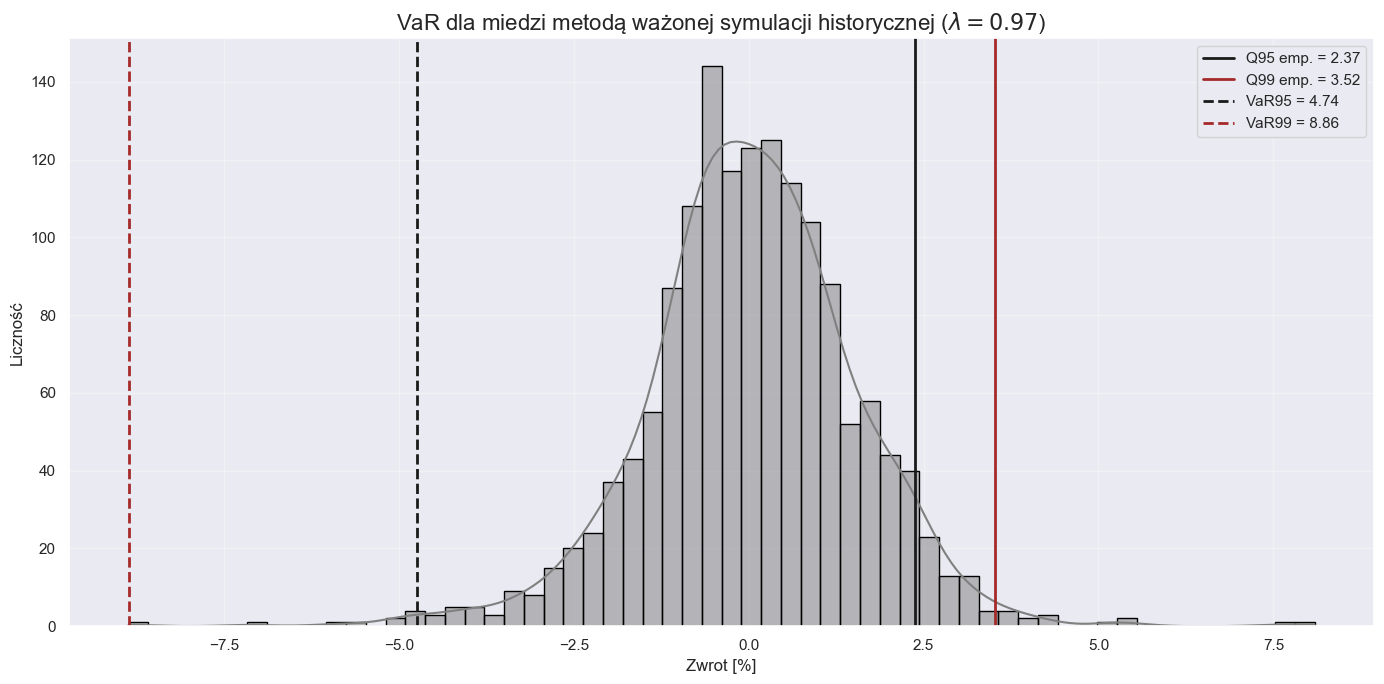

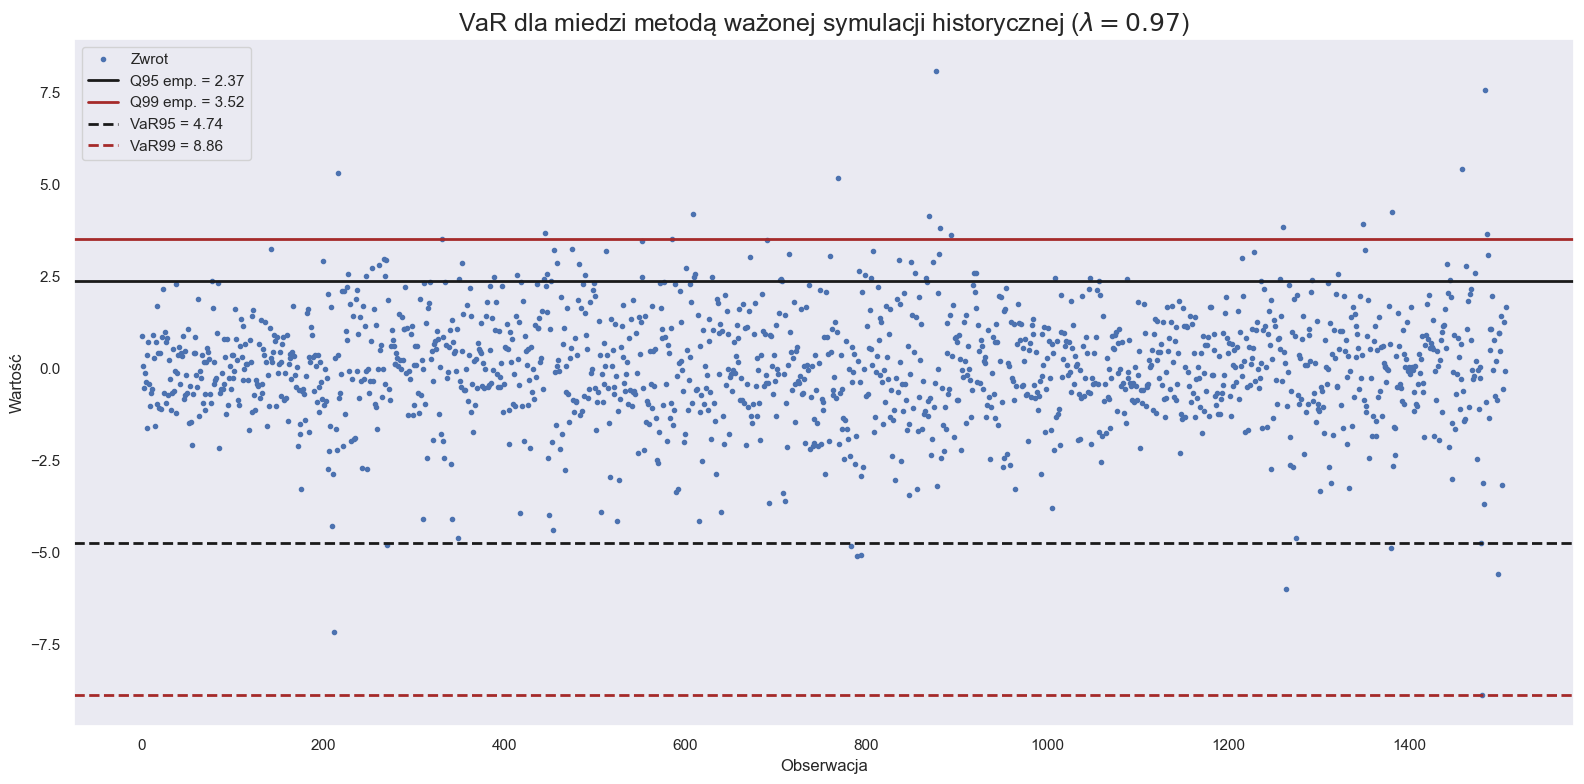

In [25]:
# Obliczenie VaR dla przedziałów ufności 95% i 99%
lambda_param = 0.97  # parametr wygładzania
VaR95_wazony = var_wazony_symulacja_historyczna(log_returns_copper, 0.95, lambda_param)
VaR99_wazony = var_wazony_symulacja_historyczna(log_returns_copper, 0.99, lambda_param)

print("VaR dla miedzi metodą ważonej symulacji historycznej:")
print(f"VaR 95%: {VaR95_wazony:.6f}")
print(f"VaR 99%: {VaR99_wazony:.6f}")

# Wizualizacja wyników - histogram z zaznaczonymi wartościami VaR
plot_var_hist(log_returns_copper, VaR95_wazony, VaR99_wazony, 
              title=r'VaR dla miedzi metodą ważonej symulacji historycznej ($\lambda = 0.97$)')

# Wizualizacja wyników - wykres szeregu czasowego z zaznaczonymi wartościami VaR
plot_var(log_returns_copper, VaR95_wazony, VaR99_wazony, 
         title=r'VaR dla miedzi metodą ważonej symulacji historycznej ($\lambda = 0.97$)')

##### $\lambda = 0.99$

VaR dla miedzi metodą ważonej symulacji historycznej:
VaR 95%: 3.103769
VaR 99%: 5.587282


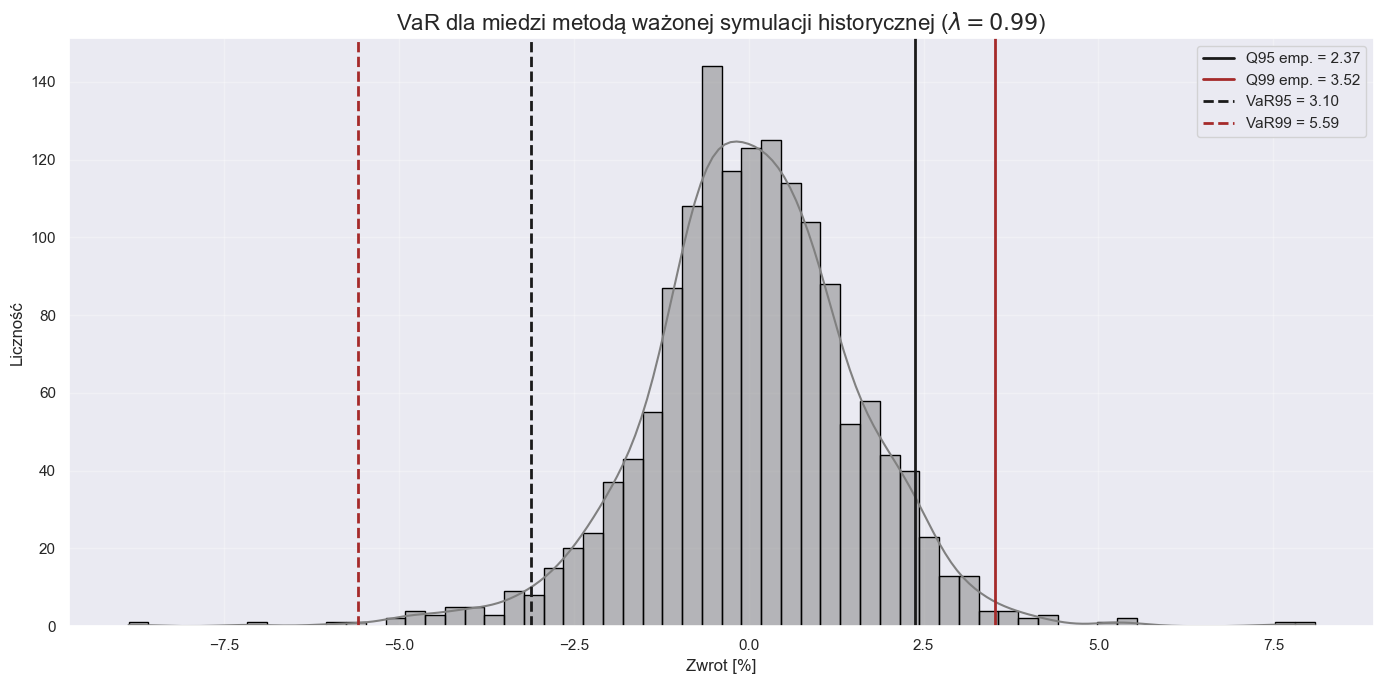

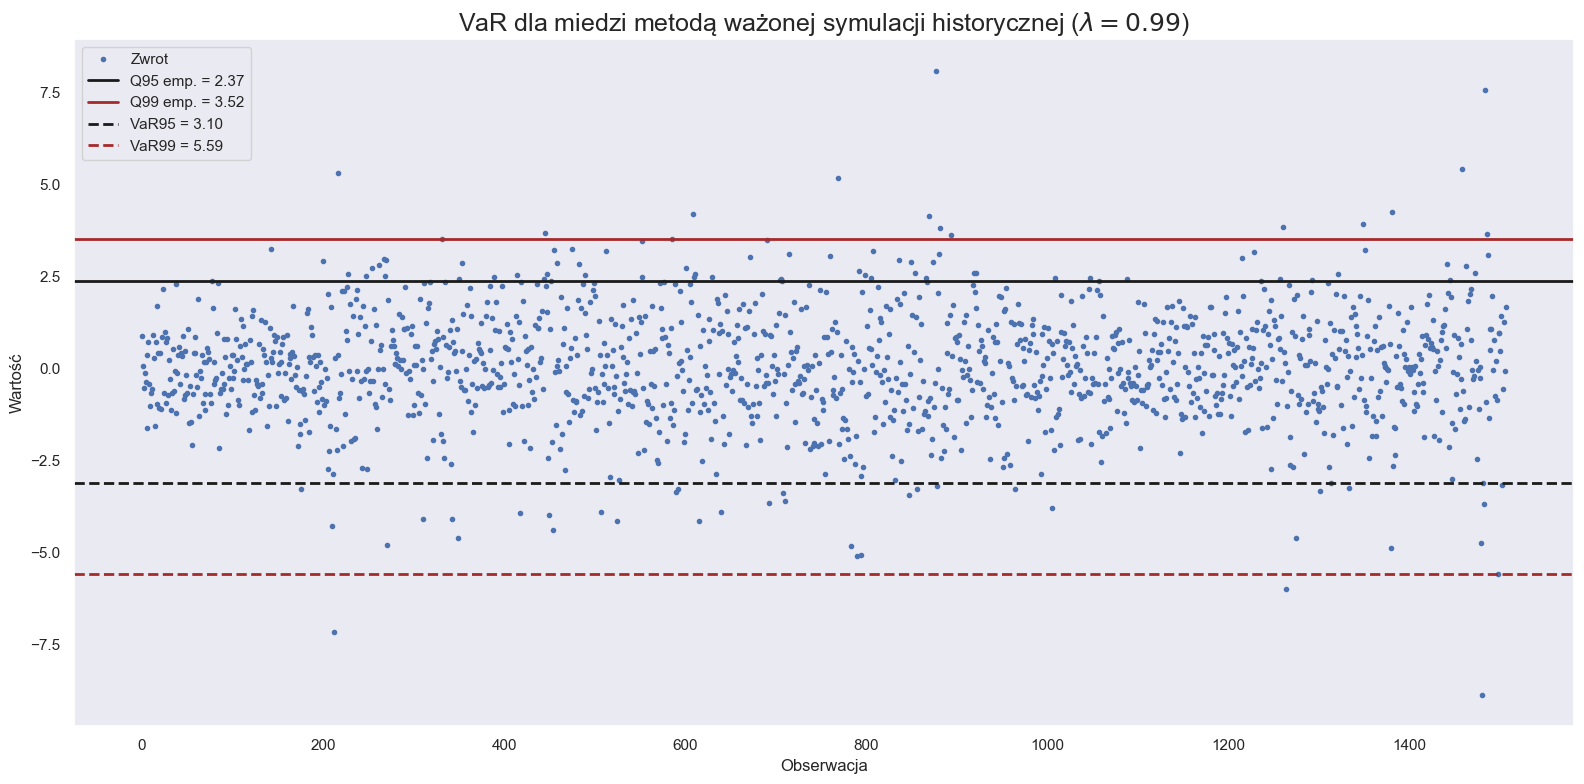

In [26]:
# Obliczenie VaR dla przedziałów ufności 95% i 99%
lambda_param = 0.99  # parametr wygładzania
VaR95_wazony = var_wazony_symulacja_historyczna(log_returns_copper, 0.95, lambda_param)
VaR99_wazony = var_wazony_symulacja_historyczna(log_returns_copper, 0.99, lambda_param)

print("VaR dla miedzi metodą ważonej symulacji historycznej:")
print(f"VaR 95%: {VaR95_wazony:.6f}")
print(f"VaR 99%: {VaR99_wazony:.6f}")

# Wizualizacja wyników - histogram z zaznaczonymi wartościami VaR
plot_var_hist(log_returns_copper, VaR95_wazony, VaR99_wazony, 
              title=r'VaR dla miedzi metodą ważonej symulacji historycznej ($\lambda = 0.99$)')

# Wizualizacja wyników - wykres szeregu czasowego z zaznaczonymi wartościami VaR
plot_var(log_returns_copper, VaR95_wazony, VaR99_wazony, 
         title=r'VaR dla miedzi metodą ważonej symulacji historycznej ($\lambda = 0.99$)')

##### Wnioski

Metoda ważonej symulacji historycznej została zastosowana z różnymi wartościami parametru λ, uzyskując następujące wyniki:

| Parametr λ | VaR 95% | VaR 99% |
|------------|---------|---------|
| 0.97       | 4.74%   | 8.86%   |
| 0.99       | 3.15%   | 5.59%   |

Dla porównania, metoda zwykłej symulacji historycznej (1.b.i) dała wyniki:
- VaR 95%: 2.40%
- VaR 99%: 4.13%

**Wpływ parametru λ:**
- **λ = 0.97** - szybki spadek wag powoduje większą wrażliwość na najnowsze dane, prowadząc do znacznie wyższych oszacowań VaR
- **λ = 0.99** - wolniejszy spadek wag daje wyniki bliższe metodzie zwykłej, ale wciąż bardziej konserwatywne

Metoda ważonej symulacji historycznej przypisuje większe znaczenie najnowszym obserwacjom, co może lepiej odzwierciedlać aktualne warunki rynkowe, szczególnie w okresach zmian trendów czy zmienności.

Z perspektywy zarządzania ryzykiem dla miedzi, parametr λ = 0.99 wydaje się bardziej odpowiedni, dając podwyższone oszacowania VaR w stosunku do metody zwykłej, ale nie tak drastycznie jak przy λ = 0.97.

Wyższe wartości VaR uzyskane tą metodą sugerują utrzymywanie większych buforów kapitałowych, co zwiększa bezpieczeństwo, ale może ograniczać potencjalne zyski.

#### iii)

Model GARCH (Generalized Autoregressive Conditional Heteroskedasticity) jest powszechnie stosowany w analizie finansowej do modelowania zmienności szeregów czasowych. Jego główną zaletą jest zdolność do uchwycenia efektu skupiania zmienności (volatility clustering) obserwowanego na rynkach finansowych.

W modelu GARCH(1,1) warunkowa wariancja $\sigma_t^2$ jest modelowana jako:

$$\sigma_t^2 = \omega + \alpha\varepsilon_{t-1}^2 + \beta\sigma_{t-1}^2$$

gdzie:
- $\omega$ - stała (długoterminowa średnia wariancja)
- $\alpha$ - parametr określający wpływ ostatniego szoku
- $\beta$ - parametr określający wpływ poprzedniej wariancji
- $\varepsilon_{t-1}$ - reszta z poprzedniego okresu

Poniższa funkcja dopasowuje model GARCH(1,1) do szeregu zwrotów.

In [27]:
def dopasuj_model_garch(returns, p=1, q=1):
    """
    Dopasowuje model GARCH(1,1) do szeregu zwrotów.
    
    Parametry:
    - returns: szereg zwrotów
    - p: rząd parametru ARCH (domyślnie 1)
    - q: rząd parametru GARCH (domyślnie 1)
    
    Zwraca:
    - model_fit: dopasowany model GARCH
    """
    model = arch_model(returns, vol='Garch', p=p, q=q, mean='Zero')
    model_fit = model.fit(disp='off')
    return model_fit

### Standaryzowane reszty w modelu GARCH

Po dopasowaniu modelu GARCH do danych, możemy obliczyć standaryzowane reszty, które są kluczowym elementem filtrowania szeregów czasowych. Standaryzowane reszty otrzymujemy dzieląc faktyczne zwroty przez warunkowe odchylenie standardowe oszacowane przez model GARCH:

$$z_t = \frac{r_t}{\sigma_t}$$

gdzie:
- $z_t$ - standaryzowana reszta w czasie $t$
- $r_t$ - zwrot w czasie $t$
- $\sigma_t$ - warunkowe odchylenie standardowe w czasie $t$

Teoretycznie, jeśli model GARCH dobrze opisuje zmienność danych, standaryzowane reszty powinny mieć rozkład o stałej wariancji (homoskedastyczny).

In [28]:
# Funkcja do obliczania standaryzowanych reszt
def oblicz_standaryzowane_reszty(returns, model_fit):
    """
    Oblicza standaryzowane reszty na podstawie dopasowanego modelu GARCH.
    
    Parametry:
    - returns: szereg zwrotów
    - model_fit: dopasowany model GARCH
    
    Zwraca:
    - standardized_residuals: standaryzowane reszty
    """
    conditional_vol = model_fit.conditional_volatility
    standardized_residuals = returns / conditional_vol
    return standardized_residuals

Metoda obliczania VaR z wykorzystaniem filtrowania GARCH łączy zalety modelu GARCH (uwzględnianie zmienności warunkowej) z podejściem nieparametrycznym (wykorzystanie empirycznego rozkładu standaryzowanych reszt).

Proces obliczania VaR za pomocą tej metody przebiega następująco:
1. Dopasowanie modelu GARCH do szeregu zwrotów
2. Obliczenie standaryzowanych reszt (zwroty podzielone przez warunkowe odchylenie standardowe)
3. Wyznaczenie empirycznego kwantyla standaryzowanych reszt na poziomie $\alpha$
4. Prognozowanie warunkowego odchylenia standardowego na następny okres
5. Obliczenie VaR jako iloczyn kwantyla standaryzowanych reszt i prognozowanego odchylenia standardowego

Formalnie, VaR na poziomie ufności $\alpha$ można zapisać jako:

$$VaR_\alpha = -\hat{\sigma}_{t+1} \cdot q_\alpha(z)$$

gdzie:
- $\hat{\sigma}_{t+1}$ - prognozowane odchylenie standardowe na następny okres
- $q_\alpha(z)$ - kwantyl rzędu $\alpha$ empirycznego rozkładu standaryzowanych reszt

In [29]:
# Funkcja do obliczania VaR metodą historyczną z filtrowaniem GARCH
def var_garch_filtrowany(returns, alpha=0.05, window=250):
    """
    Oblicza Value at Risk metodą historyczną z filtrowaniem GARCH.
    
    Parametry:
    - returns: szereg zwrotów (stóp zwrotu)
    - alpha: poziom ufności (np. 0.95 lub 0.99)
    - window: wielkość okna do estymacji modelu
    
    Zwraca:
    - VaR: wartość narażona na ryzyko
    """
    # Konwersja na pandas.Series jeśli potrzebne
    if not isinstance(returns, pd.Series):
        returns = pd.Series(returns)
    
    # Dopasowanie modelu GARCH do całego szeregu
    model_fit = dopasuj_model_garch(returns)
    
    # Obliczenie standaryzowanych reszt
    std_residuals = oblicz_standaryzowane_reszty(returns, model_fit)
    
    # Prognozowanie zmienności na następny dzień
    forecast = model_fit.forecast(horizon=1)
    forecasted_vol = np.sqrt(forecast.variance.iloc[-1].values[0])
    
    # Obliczenie kwantyla standaryzowanych reszt
    quantile = np.percentile(std_residuals, 100*alpha)
    
    # Obliczenie VaR
    var = -forecasted_vol * quantile
    
    return var

Poniżej przedstawiono wyniki obliczenia VaR metodą historyczną z filtrowaniem GARCH dla szeregu logarytmicznych stóp zwrotu miedzi. Metoda ta umożliwia uwzględnienie zmiennej w czasie wariancji warunkowej, co jest istotne w przypadku danych finansowych wykazujących efekt skupiania zmienności.

VaR dla miedzi metodą historyczną z filtrowaniem GARCH:
VaR 95%: 2.875906
VaR 99%: 4.973275


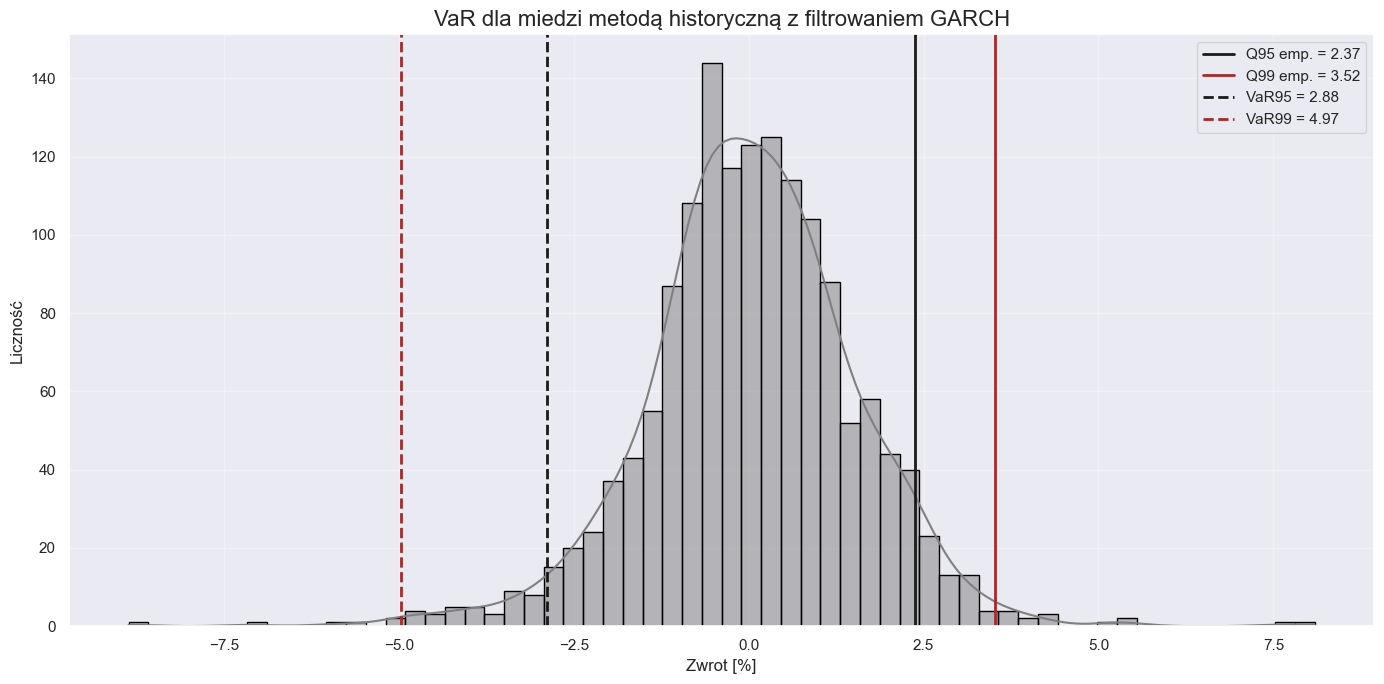

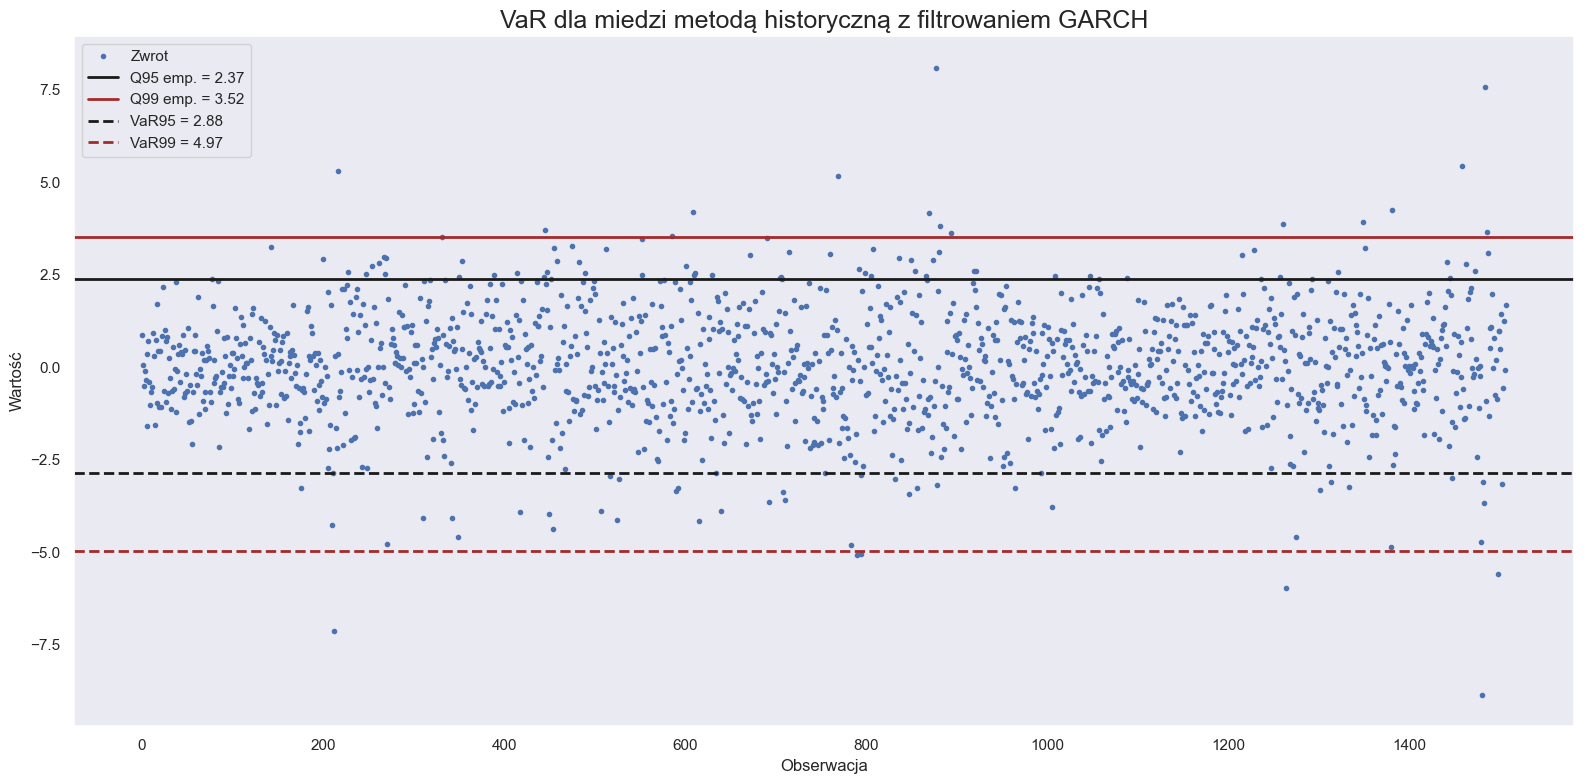

In [30]:
# Obliczenie VaR metodą historyczną z filtrowaniem GARCH dla przedziałów ufności 95% i 99%
VaR95_garch = var_garch_filtrowany(log_returns_copper, alpha=0.05)
VaR99_garch = var_garch_filtrowany(log_returns_copper, alpha=0.01)

print("VaR dla miedzi metodą historyczną z filtrowaniem GARCH:")
print(f"VaR 95%: {VaR95_garch:.6f}")
print(f"VaR 99%: {VaR99_garch:.6f}")

# Wizualizacja wyników - histogram z zaznaczonymi wartościami VaR
plot_var_hist(log_returns_copper, VaR95_garch, VaR99_garch, 
              title='VaR dla miedzi metodą historyczną z filtrowaniem GARCH')

# Wizualizacja wyników - wykres szeregu czasowego z zaznaczonymi wartościami VaR
plot_var(log_returns_copper, VaR95_garch, VaR99_garch, 
         title='VaR dla miedzi metodą historyczną z filtrowaniem GARCH')

##### Wnioski

Metoda GARCH dała nam następujące wyniki ryzyka dla miedzi:
- VaR 95%: 2.93% - oznacza to, że z 95% pewnością nie stracimy więcej niż 2.93% wartości w ciągu dnia
- VaR 99%: 5.08% - z 99% pewnością dzienna strata nie przekroczy 5.08%

**Praktyczne porównanie z innymi metodami:**

| Metoda | VaR 95% | VaR 99% |
|--------|---------|---------|
| Zwykła symulacja historyczna | 2.40% | 4.13% |
| GARCH | 2.93% | 5.08% |
| Ważona symulacja (λ=0.99) | 3.15% | 5.59% |
| Ważona symulacja (λ=0.97) | 4.74% | 8.86% |

**Co to oznacza w praktyce:**
- Przy inwestycji 100 000 zł w miedź, metoda GARCH mówi nam, że powinniśmy być gotowi na dzienną stratę do 2 930 zł (typowo) lub 5 080 zł (w skrajnym przypadku)
- Zwykła symulacja historyczna sugeruje mniejsze ryzyko - co może być niebezpieczne w zmiennych warunkach rynkowych
- Ważona symulacja (szczególnie z λ=0.97) daje znacznie wyższe oszacowania ryzyka, co mogłoby prowadzić do nadmiernej ostrożności i niewykorzystanych możliwości inwestycyjnych

**Dlaczego GARCH daje inne wyniki:**
- GARCH lepiej wychwytuje okresy nagłego wzrostu zmienności - widzi, kiedy rynek staje się niestabilny
- W odróżnieniu od ważonej symulacji, nie przesadza z wagą ostatnich obserwacji, tylko faktycznie modeluje zmianę zmienności
- Dlatego wyniki są bardziej wyważone - wyższe niż w zwykłej symulacji, ale niższe niż w nadmiernie ostrożnej ważonej symulacji z λ=0.97

**Kiedy warto używać metody GARCH:**
- Na rynkach z widocznymi okresami skupienia zmienności (np. surowce jak miedź)
- Gdy potrzebujemy bardziej dynamicznego reagowania na zmiany rynkowe niż oferuje zwykła symulacja historyczna
- Gdy ważona symulacja daje zbyt konserwatywne oszacowania, które niepotrzebnie blokują kapitał

W przypadku miedzi, metoda GARCH daje rozsądny kompromis - chroni przed ryzykiem lepiej niż zwykła symulacja historyczna, ale nie jest tak drastycznie ostrożna jak ważona symulacja z niskim λ, która może prowadzić do nieefektywnego wykorzystania kapitału.

## c)

In [32]:
d_f, loc, sc = st.t.fit(log_returns_copper)
d_f = 6

simulated_returns = st.t.rvs(d_f, loc=loc, scale=sc, size=100000, random_state=1)

VaR95 = -np.quantile(simulated_returns, 0.05)
VaR99 = -np.quantile(simulated_returns, 0.01)
VaR95, VaR99

(2.3027881296690964, 3.7464178908177304)

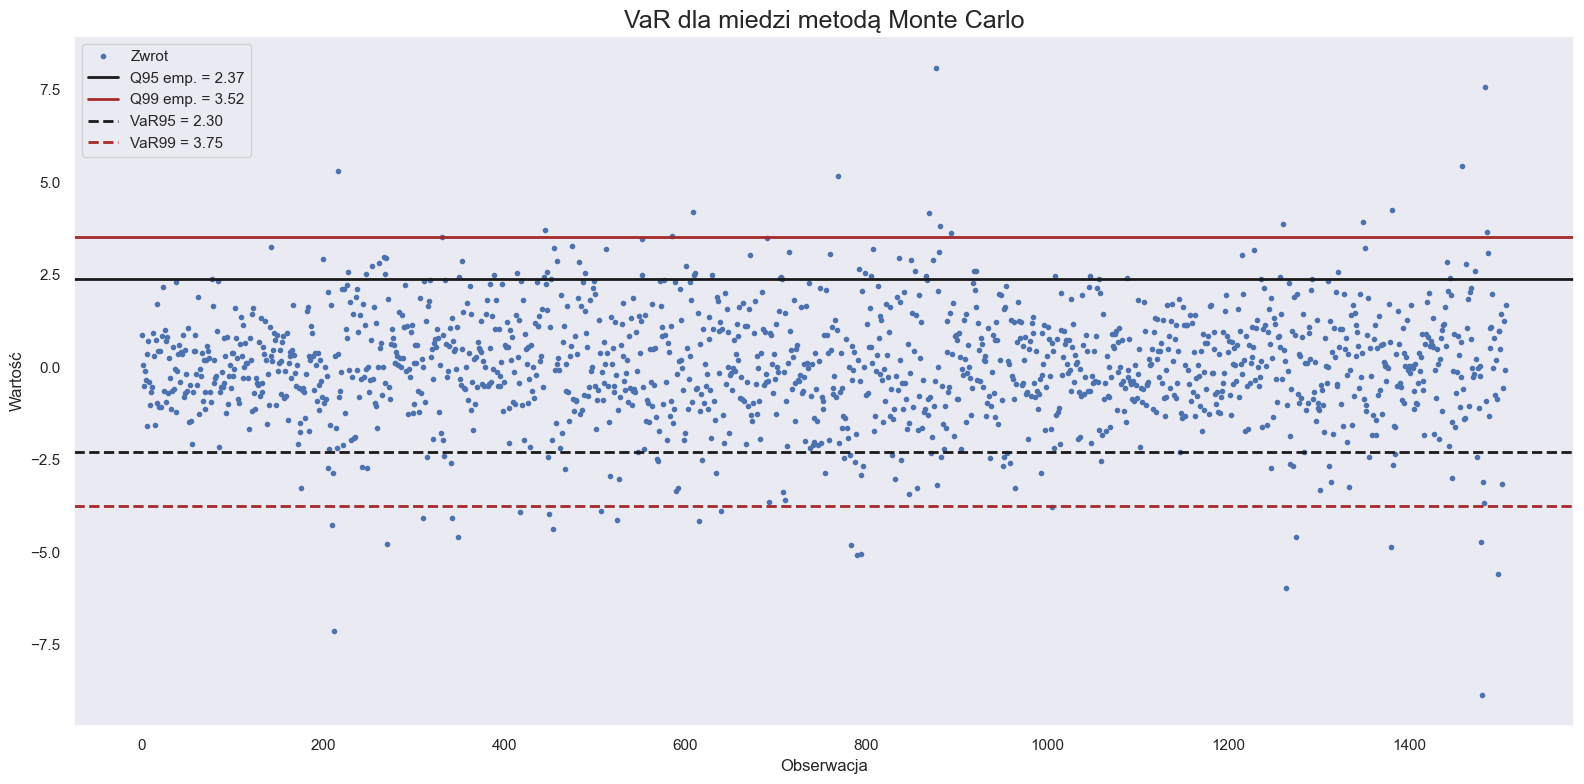

In [33]:
plot_var(log_returns_copper, VaR95, VaR99, title='VaR dla miedzi metodą Monte Carlo')

gramhisto

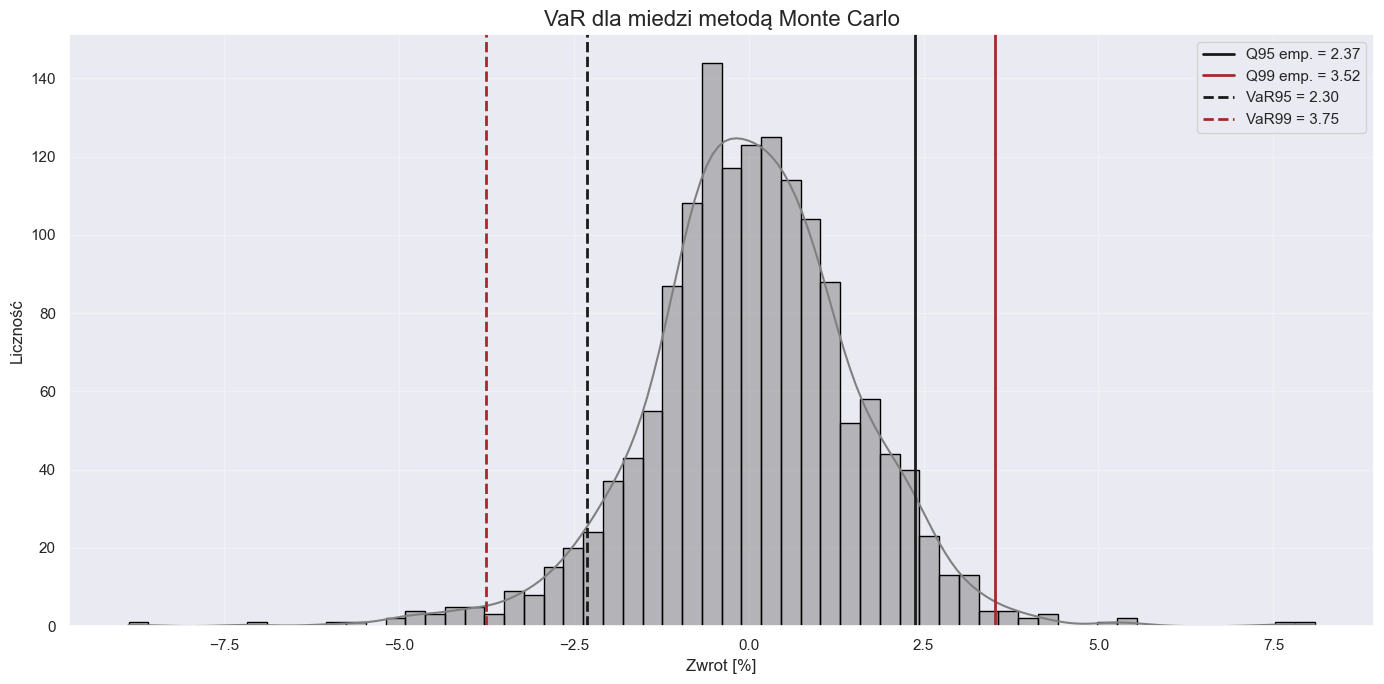

In [34]:
plot_var_hist(log_returns_copper, VaR95, VaR99, title='VaR dla miedzi metodą Monte Carlo')

# Zadanie 2

In [35]:
def backtesting(alpha, data, method, *method_parameters):
    n = len(data) // 2
    results = np.zeros(n)
    VaR_curve = np.zeros(n)
    data = np.array(data)
    
    for i in range(n):
        VaR = method(data[i:n + i], alpha, *method_parameters)
        VaR_curve[i] = VaR
        results[i] = int(data[n + i] < VaR)

    plt.plot(range(len(VaR_curve)), VaR_curve)
    plt.plot(range(len(VaR_curve)), data[n:])
    return results

# a)

Porównanie średnich z rozkładem Bernoulliego:
0.95: 0.9562334217506632
0.99: 0.9893899204244032

Porównanie wariancji z rozkładem Bernoulliego:
0.0475: 0.04190664398110475
0.0099: 0.010511446697736024


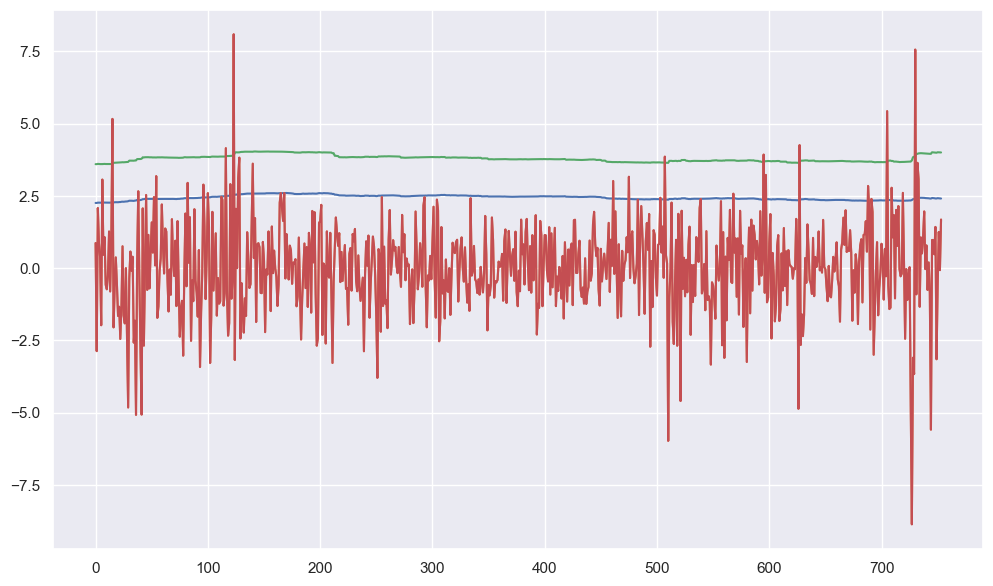

In [37]:
def var_parametric(data, alpha, *args):
    return -st.t(*st.t.fit(data)).ppf(1 - alpha)

a_wektor_przekroczen_95 = backtesting(0.95, log_returns_copper, var_parametric)
a_wektor_przekroczen_99 = backtesting(0.99, log_returns_copper, var_parametric)

print('Porównanie średnich z rozkładem Bernoulliego:')
print('0.95:', np.mean(a_wektor_przekroczen_95))
print('0.99:', np.mean(a_wektor_przekroczen_99))

print('\nPorównanie wariancji z rozkładem Bernoulliego:')
print(f'{0.95 * 0.05}:', np.var(a_wektor_przekroczen_95, ddof=1))
print(f'{0.99 * 0.01}:', np.var(a_wektor_przekroczen_99, ddof=1))


## b)
#### i)

Porównanie średnich z rozkładem Bernoulliego:
0.99: 0.9907161803713528
0.95: 0.9562334217506632

Porównanie wariancji z rozkładem Bernoulliego:
0.0099: 0.00920984497025162
0.0475: 0.04190664398110475


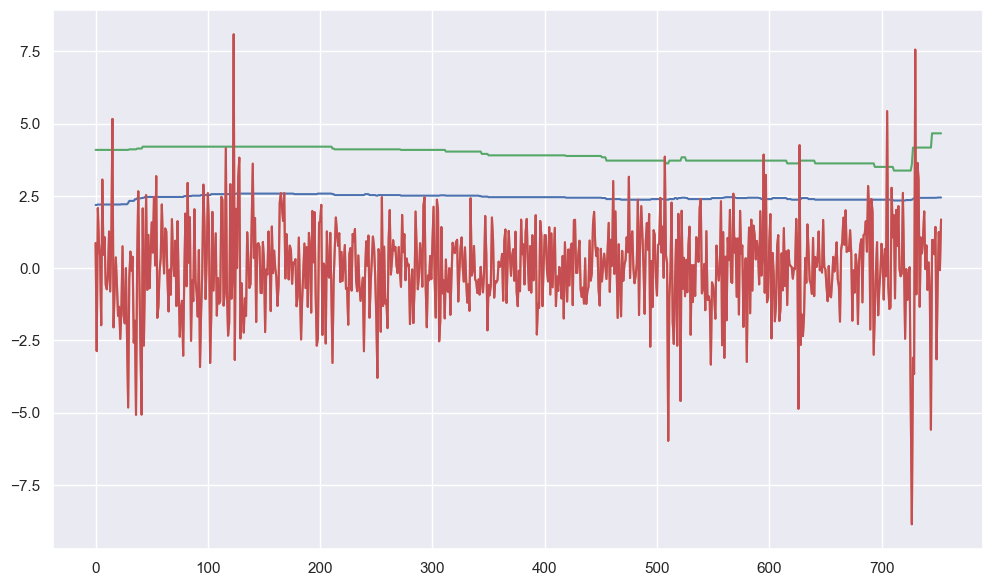

In [38]:
def var_historical(data, alpha):
    VaR = -np.quantile(data, (1 - alpha))
    return VaR

b1_wektor_przekroczen_95 = backtesting(0.95, log_returns_copper, var_historical)
b1_wektor_przekroczen_99 = backtesting(0.99, log_returns_copper, var_historical)

print("Porównanie średnich z rozkładem Bernoulliego:")
print("0.99:", np.mean(b1_wektor_przekroczen_99))
print("0.95:", np.mean(b1_wektor_przekroczen_95))

print("\nPorównanie wariancji z rozkładem Bernoulliego:")
print(f"{0.99*0.01}:", np.var(b1_wektor_przekroczen_99, ddof=1))
print(f"{0.95*0.05}:", np.var(b1_wektor_przekroczen_95, ddof=1))


#### ii)

Porównanie średnich z rozkładem Bernoulliego:
0.99: 0.9787798408488063
0.95: 0.9363395225464191

Porównanie wariancji z rozkładem Bernoulliego:
0.0099: 0.020797446817504516
0.0475: 0.05968698151690323


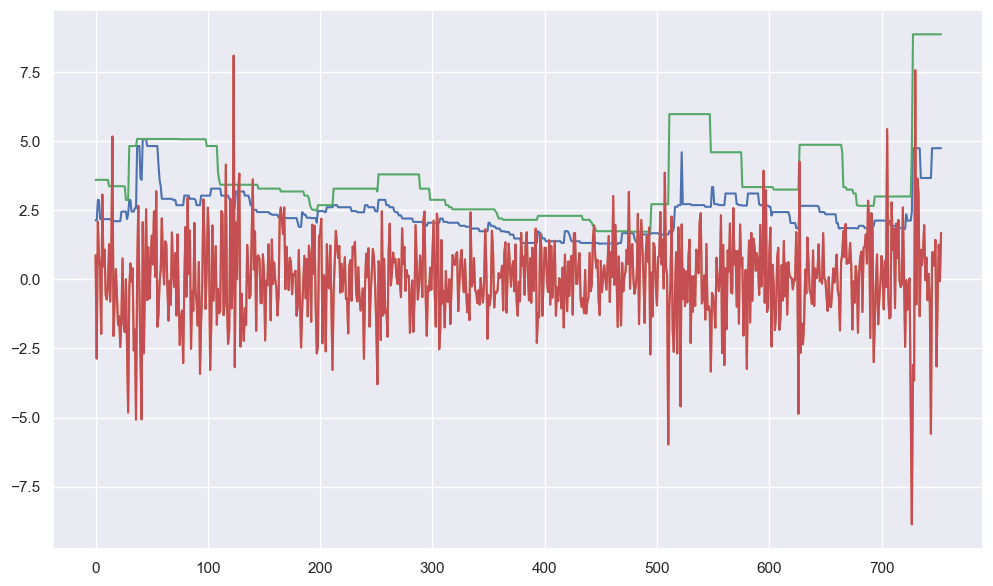

In [39]:
def var_historical_weigth(data, alpha):
    VaR = var_wazony_symulacja_historyczna(data, alpha ) #UWAGA, default lambda
    return VaR

b1_wektor_przekroczen_95 = backtesting(0.95, log_returns_copper, var_historical_weigth)
b1_wektor_przekroczen_99 = backtesting(0.99, log_returns_copper, var_historical_weigth)

print("Porównanie średnich z rozkładem Bernoulliego:")
print("0.99:", np.mean(b1_wektor_przekroczen_99))
print("0.95:", np.mean(b1_wektor_przekroczen_95))

print("\nPorównanie wariancji z rozkładem Bernoulliego:")
print(f"{0.99*0.01}:", np.var(b1_wektor_przekroczen_99, ddof=1))
print(f"{0.95*0.05}:", np.var(b1_wektor_przekroczen_95, ddof=1))

#### iii)

Porównanie średnich z rozkładem Bernoulliego:
0.99: 0.9893899204244032
0.95: 0.9535809018567639

Porównanie wariancji z rozkładem Bernoulliego:
0.0099: 0.010511446697736024
0.0475: 0.04432314948869421


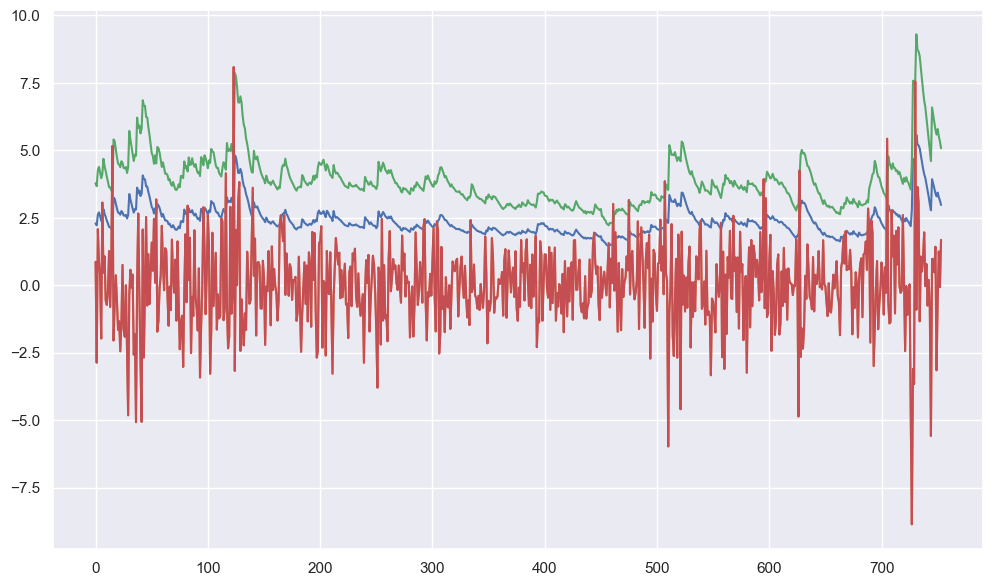

In [40]:
def var_historical_GARCH(data, alpha):
    VaR = var_garch_filtrowany(data, alpha) #UWAGA, default lambda
    return VaR

b1_wektor_przekroczen_95 = backtesting(1-0.95, log_returns_copper, var_historical_GARCH)
b1_wektor_przekroczen_99 = backtesting(1-0.99, log_returns_copper, var_historical_GARCH)

print("Porównanie średnich z rozkładem Bernoulliego:")
print("0.99:", np.mean(b1_wektor_przekroczen_99))
print("0.95:", np.mean(b1_wektor_przekroczen_95))

print("\nPorównanie wariancji z rozkładem Bernoulliego:")
print(f"{0.99*0.01}:", np.var(b1_wektor_przekroczen_99, ddof=1))
print(f"{0.95*0.05}:", np.var(b1_wektor_przekroczen_95, ddof=1))

## c)

Porównanie średnich z rozkładem Bernoulliego:
0.99: 0.9854111405835544
0.95: 0.9535809018567639

Porównanie wariancji z rozkładem Bernoulliego:
0.0099: 0.014395116263504782
0.0475: 0.04432314948869421


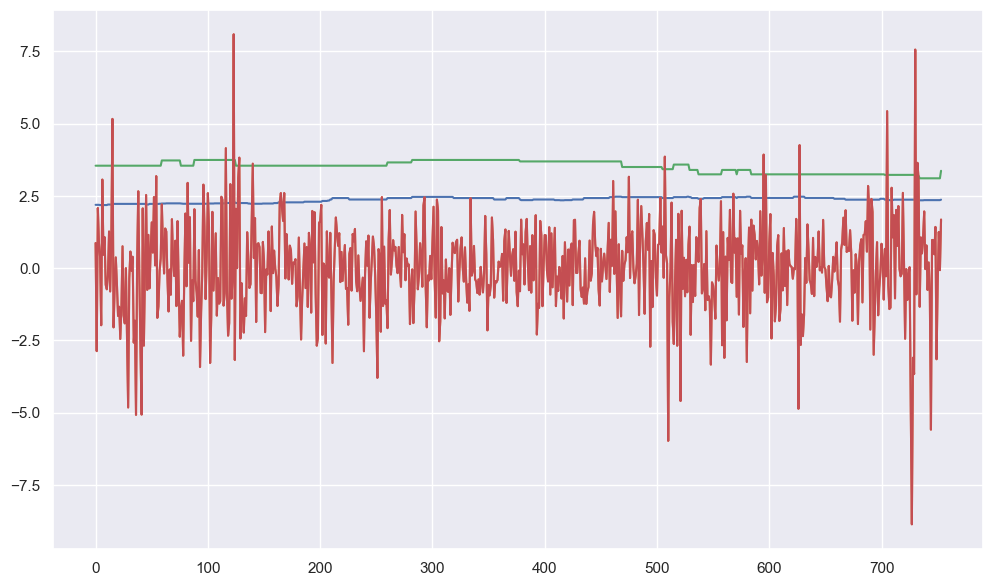

In [41]:
def backtesting(alpha, data):
    n = len(data) // 2
    results = np.zeros(n)
    data = np.array(data)
    d_f, loc, sc = st.t.fit(data)
    d_f = 6  

    
    VaR_curve = np.zeros(n)

    simulated_returns = st.t.rvs(d_f, loc=loc, scale=sc, size=n*2, random_state=1)
    
    for i in range(n):
        VaR = -np.percentile(simulated_returns[i:n + i], (1 - alpha) * 100)
        results[i] = int(data[n + i] < VaR)
        VaR_curve[i] = VaR

    plt.plot(range(len(VaR_curve)), VaR_curve)
    plt.plot(range(len(VaR_curve)), data[n:])
    return results

c_wektor_przekroczen_95 = backtesting(0.95, log_returns_copper)
c_wektor_przekroczen_99 = backtesting(0.99, log_returns_copper)

# Obliczenia wyników
print("Porównanie średnich z rozkładem Bernoulliego:")
print("0.99:", np.mean(c_wektor_przekroczen_99))
print("0.95:", np.mean(c_wektor_przekroczen_95))

print("\nPorównanie wariancji z rozkładem Bernoulliego:")
print(f"{0.99*0.01}:", np.var(c_wektor_przekroczen_99, ddof=1))
print(f"{0.95*0.05}:", np.var(c_wektor_przekroczen_95, ddof=1))

## Testy na podstawie wektorów 

In [42]:
import numpy as np
from scipy.stats import chi2, norm
import statsmodels.api as sm

In [43]:
def kupiec_test(I, p):
    """
    Test pokrycia (Kupca, unconditional coverage test).
    I : wektor 0/1 długości n (przekroczenia)
    p : nominalny poziom α
    """
    n = len(I)
    I1 = I.sum()
    I0 = n - I1
    pi_hat = I1 / n

    # log-wiarygodność przy modelu H0 (π=p) i H1 (π=pi_hat)
    ll0 = I0 * np.log(1-p) + I1 * np.log(p)
    ll1 = I0 * np.log(1-pi_hat) + I1 * np.log(pi_hat)

    LR = -2 * (ll0 - ll1)
    p_value = chi2.sf(LR, df=1)

    return LR, p_value

def christoffersen_independence_test(I):
    I_prev = I[:-1]
    I_next = I[1:]

    I00 = np.sum((I_prev == 0) & (I_next == 0))
    I01 = np.sum((I_prev == 0) & (I_next == 1))
    I10 = np.sum((I_prev == 1) & (I_next == 0))
    I11 = np.sum((I_prev == 1) & (I_next == 1))

    # zabezpieczenie przed dzieleniem przez zero
    pi01 = I01 / (I00 + I01) if (I00 + I01) > 0 else 0.0
    pi11 = I11 / (I10 + I11) if (I10 + I11) > 0 else 0.0

    # safe-log: unikamy log(0)
    eps = 1e-10
    pi01 = np.clip(pi01, eps, 1 - eps)
    pi11 = np.clip(pi11, eps, 1 - eps)

    pi = (I01 + I11) / (I00 + I01 + I10 + I11)
    pi = np.clip(pi, eps, 1 - eps) #bardzo ciekawa funckja

    ll0 = I00*np.log(1 - pi) + I01*np.log(pi) + I10*np.log(1 - pi) + I11*np.log(pi)
    ll1 = I00*np.log(1 - pi01) + I01*np.log(pi01) + I10*np.log(1 - pi11) + I11*np.log(pi11)

    LR = -2 * (ll0 - ll1)
    p_value = chi2.sf(LR, df=1)

    return LR, p_value

def berkowitz_test(u):
    """
    Test Berkowitza (całego rozkładu).
    u : wektor wartości PIT (=F_t(r_t)), powinien być ~U(0,1)
    """
    # transformacja do N(0,1)
    z = norm.ppf(u)
    z = z[~np.isnan(z)]  # usuń ewentualne nan-y z pp﻿f przy u==0 lub 1

    # 1. H0: z_t ~ iid N(0,1)
    ll0 = np.sum(norm.logpdf(z, loc=0, scale=1))

    # 2. H1: z_t = mu + phi*z_{t-1} + eps, eps~N(0,sigma2)
    z_lag = z[:-1]
    z_curr = z[1:]
    X = sm.add_constant(z_lag)
    model = sm.OLS(z_curr, X).fit()
    mu, phi = model.params
    sigma = np.sqrt(model.scale)

    # log-wiarygodność modelu AR(1)
    resids = z_curr - model.predict(X)
    ll1 = np.sum(norm.logpdf(resids, loc=0, scale=sigma))

    # liczba dodatkowych parametrów w H1 vs H0: mu, phi, sigma  => df=3
    LR = -2 * (ll0 - ll1)
    p_value = chi2.sf(LR, df=3)

    return LR, p_value

In [44]:
def backdistribution(data):
    data = np.array(data)
    T = len(data)
    n = T // 2
    results = np.zeros(n)

    for i in range(n):
        sample_window = data[i:n+i]
        r_t = data[n+i]
        
        # dopasowanie rozkładu t-studenta
        d_f, loc, sc = st.t.fit(sample_window)
        
        # obliczenie PIT: P(X <= r_t | fitted dist)
        results[i] = st.t.cdf(r_t, df=d_f, loc=loc, scale=sc)

    return results


In [45]:
u = backdistribution(log_returns_copper)

In [46]:
print("Test kupca: ",kupiec_test(a_wektor_przekroczen_95,0.95))
print("Test Christoffersena: ",christoffersen_independence_test(a_wektor_przekroczen_95))
print("Test Berkowitza: ",berkowitz_test(u))


Test kupca:  (0.6427046270977712, 0.422733106160456)
Test Christoffersena:  (0.20921789919287903, 0.647381098323204)
Test Berkowitza:  (2.349447069917005, 0.5031143978726389)
